# Data Deduplication using Clustering
**Objective**: Learn and implement data deduplication techniques.

**Task**: DBSCAN for Data Deduplication

**Steps**:
1. Data Set: Download a dataset containing duplicate entries for event registrations.
2. DBSCAN Clustering: Apply the DBSCAN algorithm to cluster similar registrations.
3. Identify Duplicates: Detect duplicates based on density of the clusters.
4. Refinement: Validate clusters and remove any erroneous duplicates.

Initial DataFrame shape: (815, 7)
Sample of initial DataFrame:
   Registration_ID Participant_Name  Registration_Time_Seconds  \
0              196       Person_187              348015.711606   
1              299       Person_158               20502.757575   
2              388        Person_58              127976.416476   
3              227       Person_124              143728.873282   
4              664       Person_348              348951.322703   

   Payment_Amount  Tickets_Purchased  Event_Type             Registration_Time  
0          471.47                  3  Conference 2025-01-05 09:40:15.711606386  
1          159.57                  2     Seminar 2025-01-01 14:41:42.757574969  
2          410.16                  1  Conference 2025-01-02 20:32:56.416475685  
3          361.68                  3  Conference 2025-01-03 00:55:28.873282130  
4          392.50                  1     Seminar 2025-01-05 09:55:51.322702951  
Numerical features to be used for clustering:
['Regist

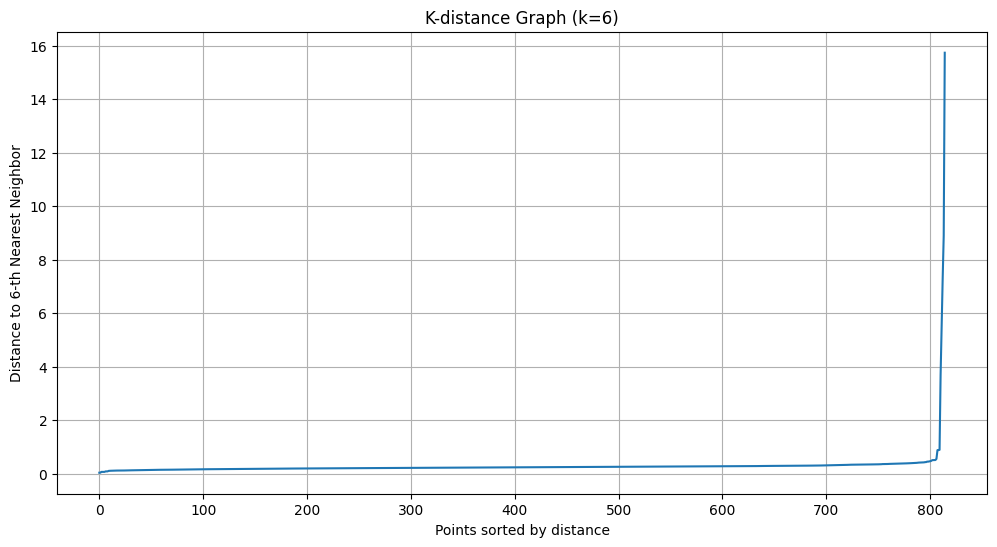


Applying DBSCAN with eps=0.5 and min_samples=6

DataFrame with DBSCAN Cluster Assignments:
   Registration_ID Participant_Name  Registration_Time_Seconds  \
0              196       Person_187              348015.711606   
1              299       Person_158               20502.757575   
2              388        Person_58              127976.416476   
3              227       Person_124              143728.873282   
4              664       Person_348              348951.322703   

   Payment_Amount  Tickets_Purchased  Event_Type  \
0          471.47                  3  Conference   
1          159.57                  2     Seminar   
2          410.16                  1  Conference   
3          361.68                  3  Conference   
4          392.50                  1     Seminar   

              Registration_Time  Cluster  
0 2025-01-05 09:40:15.711606386        0  
1 2025-01-01 14:41:42.757574969        1  
2 2025-01-02 20:32:56.416475685        2  
3 2025-01-03 00:55:28.8732

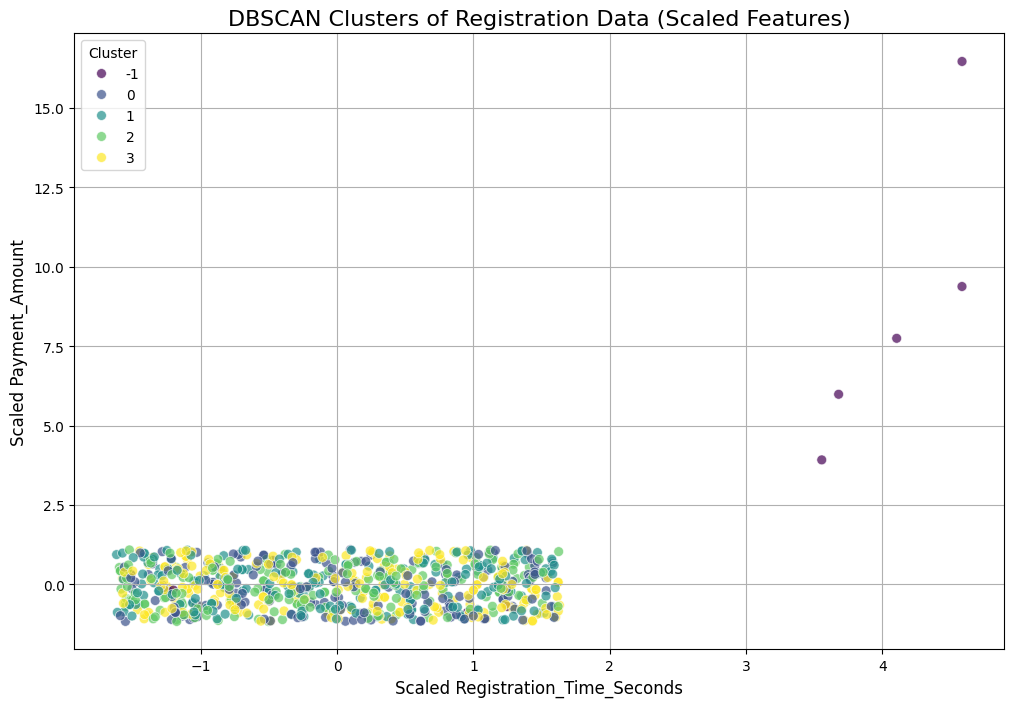

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import time

np.random.seed(42)
def generate_registration_data(num_records=1000,num_exact_dups=100,num_near_dups=50,num_outliers=10):
    start_time=pd.to_datetime('2025-01-01 09:00:00')
    end_time=pd.to_datetime('2025-01-05 17:00:00')
    time_range_seconds=(end_time-start_time).total_seconds()
    data={
        'Registration_ID':range(num_records),
        'Participant_Name':[f'Person_{i}' for i in np.random.randint(1,num_records//2,num_records)],
        'Registration_Time_Seconds':np.random.uniform(0,time_range_seconds,num_records),
        'Payment_Amount':np.random.uniform(50,500,num_records).round(2),
        'Tickets_Purchased':np.random.randint(1,5,num_records),
        'Event_Type':np.random.choice(['Conference','Workshop','Seminar','Webinar'],num_records)
    }
    df=pd.DataFrame(data)
    df['Registration_Time']=pd.to_datetime(start_time+pd.to_timedelta(df['Registration_Time_Seconds'],unit='s'))
    exact_duplicate_rows=df.sample(n=num_exact_dups,replace=False,random_state=42).copy()
    exact_duplicate_rows['Registration_ID']=np.random.randint(num_records,num_records+num_exact_dups,num_exact_dups)
    df=pd.concat([df,exact_duplicate_rows],ignore_index=True)
    near_duplicate_rows=df.sample(n=num_near_dups,replace=False,random_state=100).copy()
    near_duplicate_rows['Registration_ID']=np.random.randint(num_records+num_exact_dups,num_records+num_exact_dups+num_near_dups,num_near_dups)
    near_duplicate_rows['Payment_Amount']=near_duplicate_rows['Payment_Amount']+np.random.uniform(-5,5,num_near_dups).round(2)
    near_duplicate_rows['Registration_Time_Seconds']=near_duplicate_rows['Registration_Time_Seconds']+np.random.uniform(-3600,3600,num_near_dups)
    near_duplicate_rows['Tickets_Purchased']=near_duplicate_rows['Tickets_Purchased']+np.random.randint(-1,2,num_near_dups)
    near_duplicate_rows['Tickets_Purchased']=np.clip(near_duplicate_rows['Tickets_Purchased'],1,5)
    near_duplicate_rows['Registration_Time']=pd.to_datetime(start_time+pd.to_timedelta(near_duplicate_rows['Registration_Time_Seconds'],unit='s'))
    df=pd.concat([df,near_duplicate_rows],ignore_index=True)
    outlier_rows=df.sample(n=num_outliers,replace=False,random_state=200).copy()
    outlier_rows['Registration_ID']=np.random.randint(num_records+num_exact_dups+num_near_dups,num_records+num_exact_dups+num_near_dups+num_outliers,num_outliers)
    outlier_rows['Payment_Amount']=outlier_rows['Payment_Amount']*np.random.uniform(5,10,num_outliers)
    outlier_rows['Registration_Time_Seconds']=np.random.uniform(time_range_seconds*1.5,time_range_seconds*2,num_outliers)
    outlier_rows['Registration_Time']=pd.to_datetime(start_time+pd.to_timedelta(outlier_rows['Registration_Time_Seconds'],unit='s'))
    df=pd.concat([df,outlier_rows],ignore_index=True)
    df=df.sample(frac=1,random_state=42).reset_index(drop=True)
    return df
registration_df=generate_registration_data(num_records=700,num_exact_dups=70,num_near_dups=40,num_outliers=5)
print(f"Initial DataFrame shape: {registration_df.shape}")
print("Sample of initial DataFrame:")
print(registration_df.head())
numerical_features=['Registration_Time_Seconds','Payment_Amount','Tickets_Purchased']
print("Numerical features to be used for clustering:")
print(numerical_features)
X_numerical=registration_df[numerical_features]
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X_numerical)
X_scaled_df=pd.DataFrame(X_scaled,columns=numerical_features,index=registration_df.index)
print("\nSample of Scaled Data (used for DBSCAN):")
print(X_scaled_df.head())
min_samples_val=2*len(numerical_features)
neigh=NearestNeighbors(n_neighbors=min_samples_val)
nbrs=neigh.fit(X_scaled)
distances,indices=nbrs.kneighbors(X_scaled)
distances=np.sort(distances[:,min_samples_val-1],axis=0)
plt.figure(figsize=(12,6))
plt.plot(distances)
plt.title(f'K-distance Graph (k={min_samples_val})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {min_samples_val}-th Nearest Neighbor')
plt.grid(True)
plt.show()
chosen_eps=0.5
print(f"\nApplying DBSCAN with eps={chosen_eps} and min_samples={min_samples_val}")
dbscan=DBSCAN(eps=chosen_eps,min_samples=min_samples_val)
registration_df['Cluster']=dbscan.fit_predict(X_scaled)
print("\nDataFrame with DBSCAN Cluster Assignments:")
print(registration_df.head())
print(f"\nNumber of records per cluster:\n{registration_df['Cluster'].value_counts().sort_index()}")
print(f"Total number of clusters formed (excluding noise -1): {registration_df['Cluster'].nunique()-(1 if -1 in registration_df['Cluster'].values else 0)}")
print(f"Number of noise points (cluster -1): {(registration_df['Cluster']==-1).sum()}")
deduplicated_records=[]
duplicates_removed_count=0
retained_indices=set()
for cluster_id in sorted(registration_df['Cluster'].unique()):
    cluster_group=registration_df[registration_df['Cluster']==cluster_id].copy()
    if cluster_id==-1:
        for index,row in cluster_group.iterrows():
            if index not in retained_indices:
                deduplicated_records.append(row)
                retained_indices.add(index)
    else:
        if len(cluster_group)>1:
            cluster_group['features_hashable']=list(zip(*[cluster_group[col] for col in numerical_features]))
            sub_grouped_by_exact_features=cluster_group.groupby('features_hashable')
            for _,sub_group in sub_grouped_by_exact_features:
                if len(sub_group)>1:
                    duplicates_removed_count+=(len(sub_group)-1)
                    if sub_group.iloc[0].name not in retained_indices:
                        deduplicated_records.append(sub_group.iloc[0])
                        retained_indices.add(sub_group.iloc[0].name)
                else:
                    if sub_group.iloc[0].name not in retained_indices:
                        deduplicated_records.append(sub_group.iloc[0])
                        retained_indices.add(sub_group.iloc[0].name)
        else:
            if cluster_group.iloc[0].name not in retained_indices:
                deduplicated_records.append(cluster_group.iloc[0])
                retained_indices.add(cluster_group.iloc[0].name)
final_df=pd.DataFrame(deduplicated_records).drop(columns=['Cluster','features_hashable'],errors='ignore')
print(f"\nTotal potential duplicates identified and removed: {duplicates_removed_count}")
print(f"Original DataFrame size: {len(registration_df)}")
print(f"Deduplicated DataFrame size: {len(final_df)}")
print("\nSample of Deduplicated DataFrame:")
print(final_df.head())
print("\n--- Verification of Deduplication Impact ---")
num_exact_dups_before=registration_df.duplicated(subset=numerical_features).sum()
print(f"Number of exact duplicates (on numerical features) before DBSCAN processing: {num_exact_dups_before}")
num_exact_dups_after=final_df.duplicated(subset=numerical_features).sum()
print(f"Number of exact duplicates (on numerical features) after DBSCAN deduplication: {num_exact_dups_after}")
num_unique_records_original=registration_df.drop_duplicates(subset=numerical_features).shape[0]
print(f"Number of truly unique records (numerical features) in original DF: {num_unique_records_original}")
print(f"Number of records in final (deduplicated) DF: {len(final_df)}")
if num_exact_dups_after==0:
    print("\nSuccess: No exact duplicates (on numerical features) remaining in the deduplicated DataFrame.")
else:
    print("\nWarning: Some exact duplicates (on numerical features) might still remain. Adjust DBSCAN 'eps'/'min_samples' or refine intra-cluster deduplication logic.")
if len(numerical_features)>=2:
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=X_scaled[:,0],y=X_scaled[:,1],hue=registration_df['Cluster'],palette='viridis',legend='full',s=50,alpha=0.7)
    plt.title('DBSCAN Clusters of Registration Data (Scaled Features)',fontsize=16)
    plt.xlabel(f'Scaled {numerical_features[0]}',fontsize=12)
    plt.ylabel(f'Scaled {numerical_features[1]}',fontsize=12)
    plt.grid(True)
    plt.show()
